# Method 3 — CLIP multimodal embeddings + FAISS


Update `PDF_PATH` and run top-to-bottom.

Artifacts saved under `ARTIFACTS_DIR`:
- extracted images in `artifacts/images/`
- metadata JSON in `artifacts/`
- FAISS indexes in `artifacts/`

<!-- ## Install

```bash
pip install pymupdf pillow faiss-cpu transformers torch tqdm
``` -->


In [1]:
from doc_image_retrieval_utils import *

PDF_PATH = "Internationalisation_of_Higher_Education_in_India_Report_chapter_2.pdf"  # <-- change me
ARTIFACTS_DIR = "artifacts"

text_chunks, image_records = load_pdf_extract_text_and_images(PDF_PATH, artifacts_dir=ARTIFACTS_DIR)
save_metadata(text_chunks, image_records, artifacts_dir=ARTIFACTS_DIR)

print("Text chunks:", len(text_chunks))
print("Images:", len(image_records))
if image_records:
    print("Example image:", image_records[0])


Text chunks: 73
Images: 8
Example image: ImageRecord(image_id='p2_img1', page=2, image_path='artifacts\\images\\p2_img1.jpeg')


## 4–5) CLIP embeddings (shared space) + FAISS

In [2]:
from doc_image_retrieval_utils import *
import faiss, os

text_vecs = clip_embed_texts([c.text for c in text_chunks])
img_vecs  = clip_embed_images(image_records)

text_index = build_faiss_ip_index(text_vecs)  # already normalized
img_index  = build_faiss_ip_index(img_vecs)   # already normalized

faiss.write_index(text_index, os.path.join(ARTIFACTS_DIR, "faiss_clip_text.index"))
faiss.write_index(img_index,  os.path.join(ARTIFACTS_DIR, "faiss_clip_images.index"))
print("Saved FAISS indexes.")


d:\Mounish\multimodalrag\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Embedding images (CLIP): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

Saved FAISS indexes.


## 6) Inference: text query → retrieve text + images (CLIP)

Embedding texts (CLIP): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]


Top text chunks:
[(TextChunk(chunk_id='p18_c2', page=18, text='dia too needs to formulate a comprehensive national strategy for internationalisation of higher education. Its success will depend on leveraging the power of the world’s largest diaspora, establishment of clear implementation mechanisms, sustained institutional commitment from universities, and well-coordinated actions to overcome practical challenges. Therefore, both at the systemic and institutional levels, India needs to design contextually grounded strategies informed by global best practices to effectively advance the internationalisation of higher education. 36 TU Dresden. (2023, October 20). Brückenschlag zwischen zwei der innovativsten Wissenschaftsgemeinschaften der Welt: TU Dresden und IIT Madras gründen TransCampus-Partnerschaft. https://tu-dresden.de/tu-dresden/newsportal/news/ brueckenschlag-zwischen-zwei-der-innovativsten-wissenschaftsgemeinschaften-der-welt-tu-dresden-und-'), 0.8478127717971802), (TextChunk(

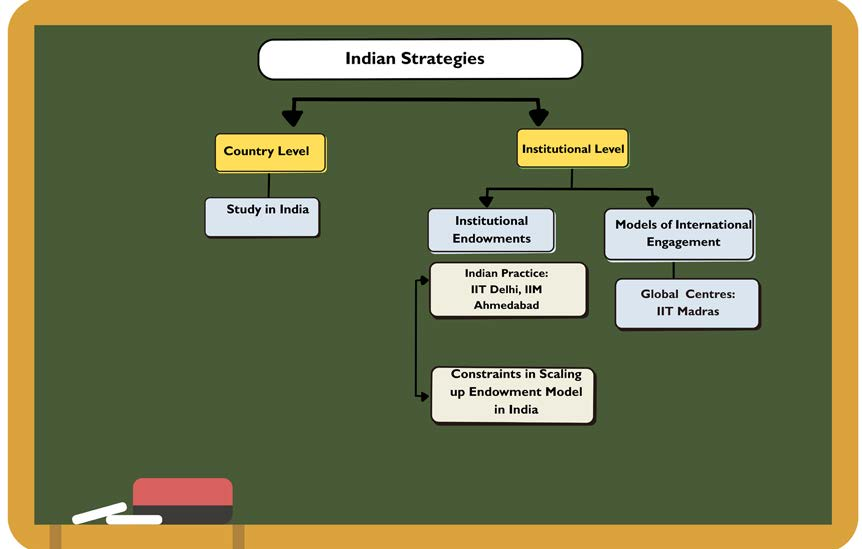

p2_img1 (page 2) score=0.286 -> artifacts\images\p2_img1.jpeg


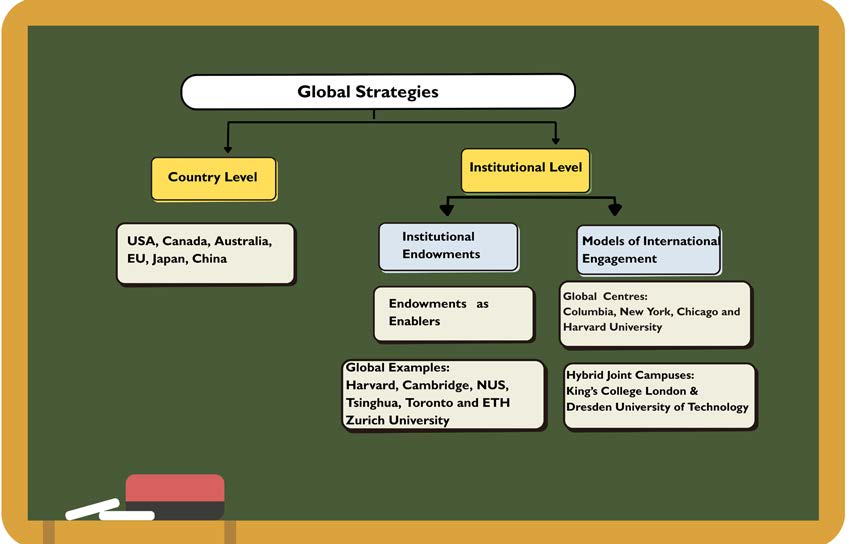

p13_img1 (page 13) score=0.285 -> artifacts\images\p13_img1.jpeg


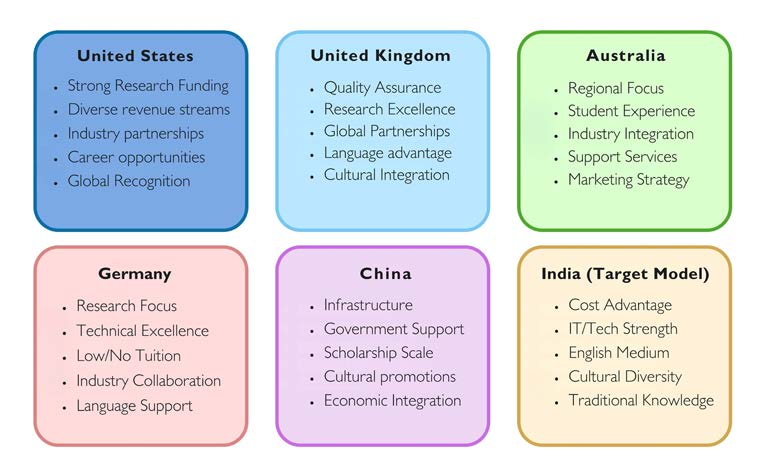

p11_img1 (page 11) score=0.259 -> artifacts\images\p11_img1.jpeg


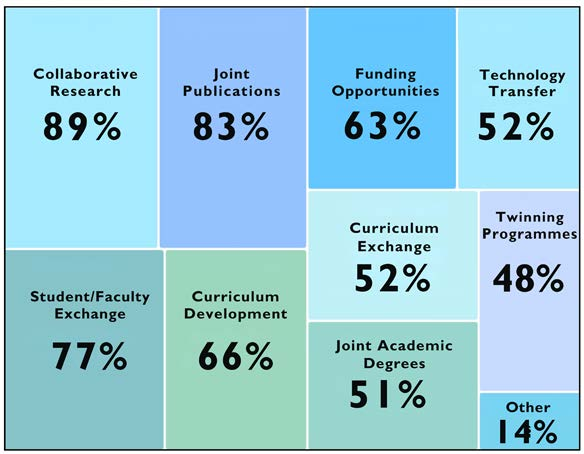

In [4]:
from doc_image_retrieval_utils import *
import faiss, os

text_index = faiss.read_index(os.path.join(ARTIFACTS_DIR, "faiss_clip_text.index"))
img_index  = faiss.read_index(os.path.join(ARTIFACTS_DIR, "faiss_clip_images.index"))

def retrieve_text(query: str, top_k: int = 5):
    q = clip_embed_texts([query])
    scores, idxs = faiss_search(text_index, q, top_k)
    return [(text_chunks[i], float(scores[j])) for j, i in enumerate(idxs)]

def retrieve_images(query: str, top_k: int = 5):
    q = clip_embed_texts([query])
    scores, idxs = faiss_search(img_index, q, top_k)
    return [(image_records[i], float(scores[j])) for j, i in enumerate(idxs)]

QUERY = "What are the indian strategies in education system "
text_hits = retrieve_text(QUERY, top_k=6)
img_hits  = retrieve_images(QUERY, top_k=6)

print("\nTop text chunks:")
print(text_hits)

print("\nTop images:")
show_images(img_hits, max_show=4)
